# Machine Learning Zoomcamp - Capstone Project 2 - Cardiology Unit Admission

As described on the Readme.md file, in this project a Linear Regression model will be trained and tuned to estimate the length of stay for patients in a Cardiology Unit.

The dataset is available at Kaggel at [this address]('https://www.kaggle.com/datasets/mansoorahmad4477/cardiology-unit-admission')

Lets download the dataset

## Dataset Download

As the dataset is available in Kaggle website, the easiest way to download it is using the kagglehub python library.

If you dont have the kagglehub library install you can install it with this command:

``` shell
pip install kagglehub
```

In [2]:
!pip install kagglehub

  Using cached kagglehub-0.3.6-py3-none-any.whl.metadata (30 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached kagglehub-0.3.6-py3-none-any.whl (51 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mansoorahmad4477/cardiology-unit-admission")
print("Path where the dataset was downloaded is: " + path)

100%|██████████| 209k/209k [00:00<00:00, 1.48MB/s]

Extracting files...
Path where the dataset was downloaded is: /home/jgrau/.cache/kagglehub/datasets/mansoorahmad4477/cardiology-unit-admission/versions/1


With this command we downloaded the dataset, but we need to store it on our project folder

In [17]:
!mkdir ./data
!mv {path}/* ./data
!ls ./data

cw_22_23_24.csv


## Load and Prepare Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction import DictVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/cw_22_23_24.csv')

In [3]:
len(df)

9573

In [ ]:
df.head()

,adm_type,shift_from,ssc,yr_nae,m_no,mrn,pt_name,sex,disease,D.O.A,D.O.D,status,consultant,L.O.S
0,Shift From,ER,No,1,1,21845698,Hara Bibi,F,STEMI,1-Jan-22,1-Jan-22,Discharge,Imran Khan,0
1,Shift From,ER,No,2,2,22000071,Taj Rehman,M,ADHF,1-Jan-22,5-Jan-22,Discharge,Malik Faisal,4
2,Shift From,ER,No,3,3,21838760,Bakhtawar Shah,M,ihd,1-Jan-22,10-Jan-22,Discharge,Asif Iqbal,9
3,Shift From,ER,No,4,4,22000251,Arasal Jan Bibi,F,NaN,1-Jan-22,7-Jan-22,Discharge,Sher Bahadar,6
4,Shift From,Neu,No,5,5,21825110,Khad Mewa,F,NaN,1-Jan-22,2-Jan-22,Discharge,Tariq Nawaz,1


### Columns Description

Based on the information available at Kaggle, this is the description of the information available in each column of the dataset:

- adm_type: Indicates the type of admission (e.g., "Shift From").
- shift_from: Specifies the source from where the patient was shifted (e.g., "ER" for Emergency Room, "Neu" for Neurology).
- ssc: Sehat Sahulat Card insurance or Health card of KPK province.
- yr_nae: Likely represents the year of the admission event.
- m_no: Month number of the admission event.
- mrn: Medical record number, a unique identifier for each patient.
- pt_name: Name of the patient.
- sex: Gender of the patient (e.g., "M" for male, "F" for female).
- disease: Diagnosis or condition of the patient (e.g., "STEMI", "ADHF").
- D.O.A: Date of admission in various formats.
- D.O.D: Date of discharge or death, also in various formats.
- status: Discharge status of the patient (e.g., "Discharge").
- consultant: Name of the consulting doctor responsible for the patient.
- L.O.S: Length of stay in the hospital, measured in days. **--> This will be our target variable**

### Data Preparation

Let us remove the following columns from the dataset:
- D.O.D feature as for a future patient we wont have this information at hand.
- mrn (Medical Record number) as it wont provide any useful information for the model.
- pt_name as the patient name wont provide provide any useful information for the model as well.

In [5]:
del df['D.O.D']
del df['mrn']
del df['pt_name']

In [6]:
df.dtypes

adm_type      object
shift_from    object
ssc           object
yr_nae         int64
m_no           int64
sex           object
disease       object
D.O.A         object
status        object
consultant    object
L.O.S          int64
dtype: object

In [7]:
# lets normalize the columns names
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('.', '')
df.columns

Index(['adm_type', 'shift_from', 'ssc', 'yr_nae', 'm_no', 'sex', 'disease',
       'doa', 'status', 'consultant', 'los'],
      dtype='object')

We can see that there are columns that can be defined as categorial variables. Lets normalize the information on those.

In [8]:
categorical_features = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_features:
    df[c] = df[c].str.lower().str.replace(' ','_')

In [9]:
for c in categorical_features:
    print('********************')
    print(df[c].value_counts())
    print('********************' + "\n\n")

********************
adm_type
shift_from    9192
ibp            194
opd            107
er              78
opd_             2
Name: count, dtype: int64
********************


********************
shift_from
er                8073
post_cath         1013
ibp                167
opd                 90
pcw                 22
                  ... 
gynae                1
ct_icu/ibp           1
amu/er               1
shift_from_cvw       1
s-pacu               1
Name: count, Length: 97, dtype: int64
********************


********************
ssc
no     5658
yes    3915
Name: count, dtype: int64
********************


********************
sex
m    5631
f    3942
Name: count, dtype: int64
********************


********************
disease
awmi            1478
iwmi             807
nstemi           745
mi               381
chb              345
                ... 
ihd_avr            1
htn_mi             1
dc_cad             1
charsadda          1
infected_ppm       1
Name: count, Length: 744, dt

In [10]:
numerical_features = list(df.dtypes[df.dtypes != 'object'].index)
numerical_features.remove('los')
numerical_features

['yr_nae', 'm_no']

### Feature Engineering

As we have a column with the Date of Admission, lets break this column in additional columns that might provide much more information to the model.

In [11]:
df['doa'] = pd.to_datetime(df['doa'], format='mixed')

In [12]:
df['doa_month'] = df['doa'].dt.month
df['doa_day_of_month'] = df['doa'].dt.day
df['doa_day_of_week'] = df['doa'].dt.day_of_week
df['doa_isweekend'] = df['doa'].dt.day_of_week>5
df['doa_quarter'] = df['doa'].dt.quarter

Now we can get rid of the column date of admission

In [13]:
del df['doa']

In [14]:
categorical_features.remove('doa')

In [15]:
df.info() # Look at the result on desease column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9573 entries, 0 to 9572
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   adm_type          9573 non-null   object
 1   shift_from        9573 non-null   object
 2   ssc               9573 non-null   object
 3   yr_nae            9573 non-null   int64 
 4   m_no              9573 non-null   int64 
 5   sex               9573 non-null   object
 6   disease           7481 non-null   object
 7   status            9573 non-null   object
 8   consultant        9573 non-null   object
 9   los               9573 non-null   int64 
 10  doa_month         9573 non-null   int32 
 11  doa_day_of_month  9573 non-null   int32 
 12  doa_day_of_week   9573 non-null   int32 
 13  doa_isweekend     9573 non-null   bool  
 14  doa_quarter       9573 non-null   int32 
dtypes: bool(1), int32(4), int64(3), object(7)
memory usage: 906.9+ KB


### Handling missing values

We can see that the only column with missing values is the column *disease*. There are multiple ways to handle this case. Among the options we could mention the following three options:
1. **Delete rows with missing values**: This would be the most simple option, but as the missing values represent around 21% of the rows, we would be missing too much data.
2. **Inpute Missing values**: This mean that we could could fill these values with a constant value or with the most frequent value. The problem with this is that we could be introducing bias to the model.
3. **Create new category for Missing Values**: By filling these values with 'missing' could be helpful as it would be considered as an additional category/value on this column. We are going with this aproach.


In [16]:
df['disease'].fillna('missing', inplace=True)

/tmp/ipykernel_92592/2012226267.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['disease'].fillna('missing', inplace=True)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9573 entries, 0 to 9572
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   adm_type          9573 non-null   object
 1   shift_from        9573 non-null   object
 2   ssc               9573 non-null   object
 3   yr_nae            9573 non-null   int64 
 4   m_no              9573 non-null   int64 
 5   sex               9573 non-null   object
 6   disease           9573 non-null   object
 7   status            9573 non-null   object
 8   consultant        9573 non-null   object
 9   los               9573 non-null   int64 
 10  doa_month         9573 non-null   int32 
 11  doa_day_of_month  9573 non-null   int32 
 12  doa_day_of_week   9573 non-null   int32 
 13  doa_isweekend     9573 non-null   bool  
 14  doa_quarter       9573 non-null   int32 
dtypes: bool(1), int32(4), int64(3), object(7)
memory usage: 906.9+ KB


Now there are no missing values in the dataset

### Preprocessing the data

We setup the transformers to numerical and categorical data using Pipelines
- In the case of numerical features, we'll scale their values in order to normalize them.
- In the case of categorical features, we'll using One Hot Encoding.

In [18]:
# Define the preprocessing steps
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Splitting the data and Train/Validate the model

In [19]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_full_train = df_full_train.los.values
y_train = df_train.los.values
y_val = df_val.los.values
y_test = df_test.los.values

In [20]:
del df_train['los']
del df_val['los']
del df_test['los']

In [21]:
# Create a pipeline that includes the preprocessor and the linear regression model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

In [22]:
# In order to help y_train data to have a normal distribution, we calculate the log values
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [23]:
# Train the model
pipeline.fit(df_train, y_train_log)

# Make predictions
y_pred = pipeline.predict(df_val)

# Evaluate the model
mse = mean_squared_error(y_val_log, y_pred)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.35023328933542736


<Axes: ylabel='Count'>

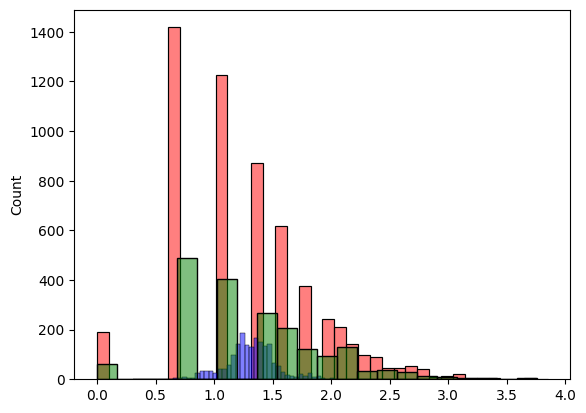

In [24]:
sns.histplot(y_train_log, color='red', alpha=0.5)
sns.histplot(y_pred, color='blue', alpha=0.5)
sns.histplot(y_val_log, color='green', alpha=0.5)

#### Reviewing this partial result

The result obtained:
- Mean Squared Error: 0.35023328933542736

Is not bad, but we can see if it can be improved. For this, we will try additional Regression models to see if any of those works better than Linear Regression model, including:
- **Ridge Regression:** Applies a L2 Regularization which adds a penalty equal to the sum of the squared values of the coefficients to the loss function.

  - The objective function for Ridge Regression is:
    $$
    \text{Minimize} \left( \sum_{i=1}^m (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^n \beta_j^2 \right)
    $$
    where $\alpha$ is the regularization strength, $\beta_j$ are the coefficients, $m$ is the number of samples, and $n$ is the number of features.
  - **Use Case:** Ridge Regression is useful when you have many correlated features and you want to retain all of them in the model but with reduced influence.  

- **Lasso Regression:** Applies a L1 Regularization which adds a penalty equal to the sum of the absolute values of the coefficients to the loss function.

  - The objective function for Lasso Regression is:
    $$
    \text{Minimize} \left( \sum_{i=1}^m (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^n |\beta_j| \right)
    $$
    where $\alpha$ is the regularization strength, $\beta_j$ are the coefficients, $m$ is the number of samples, and $n$ is the number of features.

  - **Use Case:** Lasso Regression is useful when you have a large number of features and you want to perform feature selection to identify the most important ones.


## Testing Ridge Regression

In [25]:
# Create a pipeline that includes the preprocessor and the ridge regression model, intead of LinearRegression
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', Ridge())])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(df_train, y_train_log)

# Best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Best model
ridge_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = ridge_model.predict(df_val)

# Evaluate the best model
mse = mean_squared_error(y_val_log, y_pred)

print(f'Mean Squared Error: {mse}')

Best Parameters: {'regressor__alpha': 10.0}
Mean Squared Error: 0.34334693947073797


## Testing Lasso

In [26]:
from sklearn.linear_model import Lasso

# Create a pipeline that includes the preprocessor and the Lasso regression model
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Lasso())])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(df_train, y_train_log)

# Best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Best model
lasso_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = lasso_model.predict(df_val)

# Evaluate the best model
mse = mean_squared_error(y_val_log, y_pred)
r2 = r2_score(y_val_log, y_pred)

print(f'Mean Squared Error: {mse}')


Best Parameters: {'regressor__alpha': 0.01}
Mean Squared Error: 0.36717783815120897


## Results comparison

|Model|MSE|
|---|---|
|Linear Regression|0.3502|
|Ridge Regression|0.3433|
|Lasso Regression|0.3671|

Based on this the best model would be the **Ridge Regression Model**. 

## Full Train the model.

Now that we know the best model for the job, we are going to train it with the full_train dataset and test it with the test dataset

In [27]:
y_full_train_log = np.log1p(df_full_train.los.values)
del df_full_train['los']
y_test_log = np.log1p(y_test)

In [28]:
# from the first train, we got that the best alpha value was 10.0
best_alpha = 10.0

# Create a pipeline that includes the preprocessor and the ridge regression model, intead of LinearRegression
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', Ridge(alpha=best_alpha))])

ridge_pipeline.fit(df_full_train, y_full_train_log)
y_pred = ridge_pipeline.predict(df_test)

# Evaluate the best model
mse = mean_squared_error(y_test_log, y_pred)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.3619813653551113


Just to actually see the model working, lets take one sample value and test it against the model

In [29]:
# lets take a random index from the full train dataset
rand_index = np.random.randint(0, len(y_full_train))
rand_index

test_df = df_full_train.loc[[rand_index]]
test_y = y_full_train_log[rand_index]

y_pred = ridge_pipeline.predict(test_df)
print(f'Log values => Prediction: {y_pred[0]}, Original Value: {test_y}')
print(f'Values in days => Prediction: {np.expm1(y_pred[0])}, Original Value: {np.expm1(test_y)}')


Log values => Prediction: 1.2645255856920932, Original Value: 1.0986122886681096
Values in days => Prediction: 2.541412240877741, Original Value: 1.9999999999999996


## Exporting the model to a file

In [30]:
import pickle

In [31]:
# Save the best model to a file
filename = 'ridge_regression_model_v1.pkl'
with open(filename, 'wb') as file:
    pickle.dump(ridge_model, file)

## Testing the model inporting it

In [32]:
with open('ridge_regression_model_v1.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [33]:
# using the same test_df we used before
y_pred_log = loaded_model.predict(test_df)

# Convert the predictions back to the original scale
y_pred_original = np.expm1(y_pred_log)

y_test_original = np.expm1(test_y)

print(f'Prediction: {y_pred_original[0]} \nOriginal Value: {y_test_original}')


Prediction: 2.5194887825249226 
Original Value: 1.9999999999999996


In [35]:
test_df

,adm_type,shift_from,ssc,yr_nae,m_no,sex,disease,status,consultant,doa_month,doa_day_of_month,doa_day_of_week,doa_isweekend,doa_quarter
5065,shift_from,er,yes,1006,46,m,mi,discharge,tariq_nawaz,4,5,2,False,2


In [36]:
test_df.to_json()

'{"adm_type":{"5065":"shift_from"},"shift_from":{"5065":"er"},"ssc":{"5065":"yes"},"yr_nae":{"5065":1006},"m_no":{"5065":46},"sex":{"5065":"m"},"disease":{"5065":"mi"},"status":{"5065":"discharge"},"consultant":{"5065":"tariq_nawaz"},"doa_month":{"5065":4},"doa_day_of_month":{"5065":5},"doa_day_of_week":{"5065":2},"doa_isweekend":{"5065":false},"doa_quarter":{"5065":2}}'

In [46]:
df2 = pd.read_csv('./data/cw_22_23_24.csv')

In [47]:
df2.head(1)

,adm_type,shift_from,ssc,yr_nae,m_no,mrn,pt_name,sex,disease,D.O.A,D.O.D,status,consultant,L.O.S
0,Shift From,ER,No,1,1,21845698,Hara Bibi,F,STEMI,1-Jan-22,1-Jan-22,Discharge,Imran Khan,0


In [48]:
del df2['D.O.D']
del df2['mrn']
del df2['pt_name']
del df2['L.O.S']

In [50]:
test_df

,adm_type,shift_from,ssc,yr_nae,m_no,sex,disease,status,consultant,doa_month,doa_day_of_month,doa_day_of_week,doa_isweekend,doa_quarter
5065,shift_from,er,yes,1006,46,m,mi,discharge,tariq_nawaz,4,5,2,False,2


In [54]:
for column in test_df.columns:
    if 'doa' in column:
        del test_df[column]

In [56]:
test_df['doa'] = '1-Jan-22'

In [57]:
test_df

,adm_type,shift_from,ssc,yr_nae,m_no,sex,disease,status,consultant,doa
5065,shift_from,er,yes,1006,46,m,mi,discharge,tariq_nawaz,1-Jan-22


In [62]:
test_df.to_json(orient='records')

'[{"adm_type":"shift_from","shift_from":"er","ssc":"yes","yr_nae":1006,"m_no":46,"sex":"m","disease":"mi","status":"discharge","consultant":"tariq_nawaz","doa":"1-Jan-22"}]'

## Function to prepare data

Thinking about the service that is going to receive data and make predictions, we need to make a function that:
- Receives a record in json format
- The record wont have some of the columns we need (month, day of the month, day of week, is weekend and quarter)
- returns the data with all the columns required for the model to work

In [67]:
import json

In [68]:
# Sample data
data = '''{
        "adm_type":"shift_from",
        "shift_from":"er",
        "ssc":"yes",
        "yr_nae":1006,
        "m_no":46,
        "sex":"m",
        "disease":"mi",
        "status":"discharge",
        "consultant":"tariq_nawaz",
        "doa":"1-Jan-22"
    }'''

# Parse the JSON string into a Python dictionary
data_dict = json.loads(data)

# Create a Pandas DataFrame from the dictionary
input_df = pd.DataFrame([data_dict])

In [69]:
input_df

,adm_type,shift_from,ssc,yr_nae,m_no,sex,disease,status,consultant,doa
0,shift_from,er,yes,1006,46,m,mi,discharge,tariq_nawaz,1-Jan-22
